## IMPORTS

In [1]:
import tensorflow as tf
import os
from glob import glob
!pip install -q tensorflow-io
import tensorflow_io as tfio


from matplotlib import pyplot as plt

from IPython import display
import imageio

import numpy as np
import math

## HYPERPARAMETERS

In [2]:
BUFFER_SIZE = 400
BATCH_SIZE = 2
IMG_WIDTH = 256
IMG_HEIGHT = 256

# dicom root 
# dicom_root = 'E:/dataset/Leisang/myTry/BleedingDataDCM'
# for lab ubuntu:
dicom_root = '/media/ytx/Japan_Deep_Data/dataset/LeiSang/myTry/BleedingDataDCM'
# # for home ubuntu:
# dicom_root = '/media/ytx/DL/dataset/Leisang/myTry/BleedingDataDCM'
train_path  = os.path.join(dicom_root, "train")
val_path =  os.path.join(dicom_root, "val")
print("dicom_root",dicom_root)
print("train_path",train_path)
print("val_path",val_path)

train_roots = sorted(glob(train_path + "/*"))
val_roots =  sorted(glob(val_path + "/*"))
print("train_roots", train_roots)
print("val_roots", val_roots)

print("# of train roots:", len(train_roots))
print("# of val roots:", len(val_roots))

train_dicom_paths = []
val_dicom_paths = []
for each_train in train_roots:
    temp_dicoms =  sorted(glob(each_train +'/*.DCM'))
    print("one roort len of dicoms:", len(temp_dicoms))
    train_dicom_paths = train_dicom_paths+ temp_dicoms
#     train_dicom_paths.append(sorted(glob(each + '/*.DCM')))

for each_val in val_roots:
    temp_dicoms =  sorted(glob(each_val +'/*.DCM'))
    print("one roort len of dicoms:", len(temp_dicoms))
    val_dicom_paths = val_dicom_paths+ temp_dicoms
#     train_dicom_paths.append(sorted(glob(each + '/*.DCM')))
print("# of train dicoms:", len(train_dicom_paths))
print("# of val dicoms:", len(val_dicom_paths))    

total_num_batches_per_epoch = math.ceil(len(train_dicom_paths) / BATCH_SIZE)

total_num_batches_per_val = math.ceil(len(val_dicom_paths) / BATCH_SIZE)
print("batch size:", BATCH_SIZE)
print("total_num_batches per epoch:", total_num_batches_per_epoch)
print("input shape:", [IMG_HEIGHT, IMG_WIDTH])


dicom_root E:/dataset/Leisang/myTry/BleedingDataDCM
train_path E:/dataset/Leisang/myTry/BleedingDataDCM\train
val_path E:/dataset/Leisang/myTry/BleedingDataDCM\val
train_roots ['E:/dataset/Leisang/myTry/BleedingDataDCM\\train\\ZA-006_000', 'E:/dataset/Leisang/myTry/BleedingDataDCM\\train\\ZA-008_000', 'E:/dataset/Leisang/myTry/BleedingDataDCM\\train\\ZA-012_000', 'E:/dataset/Leisang/myTry/BleedingDataDCM\\train\\ZA-015_001', 'E:/dataset/Leisang/myTry/BleedingDataDCM\\train\\ZA-017_001', 'E:/dataset/Leisang/myTry/BleedingDataDCM\\train\\ZA-019_001', 'E:/dataset/Leisang/myTry/BleedingDataDCM\\train\\ZA-020_002', 'E:/dataset/Leisang/myTry/BleedingDataDCM\\train\\ZA-021_001', 'E:/dataset/Leisang/myTry/BleedingDataDCM\\train\\ZA-022_001', 'E:/dataset/Leisang/myTry/BleedingDataDCM\\train\\ZA-023_001', 'E:/dataset/Leisang/myTry/BleedingDataDCM\\train\\ZA-024_001', 'E:/dataset/Leisang/myTry/BleedingDataDCM\\train\\ZA-027_001', 'E:/dataset/Leisang/myTry/BleedingDataDCM\\train\\ZA-029_001', 'E:/

## FUNCTIONS FOR LOADING INPUTS

In [3]:
@tf.function()
def load(image_file):
    image_bytes = tf.io.read_file(image_file)
    image = tfio.image.decode_dicom_image(image_bytes, dtype=tf.uint16)  
    # tf.uint16: 16-bit unsigned integer  [0, 65535]
    print(image_bytes)
    print("load image:", image.shape)
#     w = tf.shape(image)[1]

#     input_image = tf.cast(image, tf.int16)

    input_image = tf.cast(image, tf.float32)
    target_image = input_image


    return input_image, target_image

Tensor("ReadFile:0", shape=(), dtype=string)
load image: (None, None, None, None)


Text(0.5, 1.0, 'target range:[30720.0, 34836.0]')

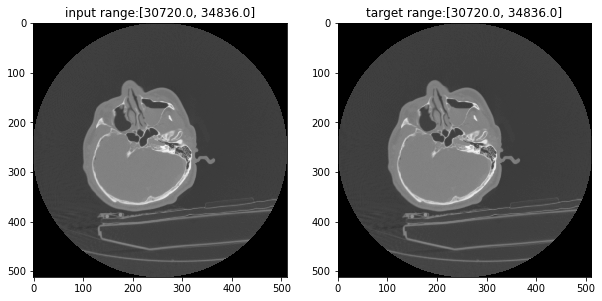

In [4]:
# # check the load fucntion
# single_dicom_path =  train_dicom_paths[1]
# print("single_dicom_path:", single_dicom_path)
# # input, target = load(single_dicom_path)
# input, target = load('E:\\dataset\\Leisang\\myTry\\BleedingDataDCM\\train\\ZA-006_000\\00001083.DCM')
# # for home ubuntu system
# input, target = load('/media/ytx/DL/dataset/Leisang/myTry/BleedingDataDCM/train/ZA-006_000/00000001.DCM')

# # for lab ubuntu system
input, target = load('/media/ytx/Japan_Deep_Data/dataset/LeiSang/myTry/BleedingDataDCM/train/ZA-006_000/00000001.DCM')
fig, axes = plt.subplots(1,2, figsize=(10,10))
axes[0].imshow(np.squeeze(input.numpy()), cmap='gray')
axes[0].set_title('input range:[{}, {}]'.format((input.numpy().min()), np.max(input.numpy())))
axes[1].imshow(np.squeeze(target.numpy()), cmap='gray')
axes[1].set_title('target range:[{}, {}]'.format(np.min(target), np.max(target)))

## PREPROCESSING


In [5]:
def resize(input, target):
    resized_input = tf.image.resize(input, [IMG_HEIGHT, IMG_WIDTH],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    resized_target = tf.image.resize(target, [IMG_HEIGHT, IMG_WIDTH],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    resized_input =  tf.reshape(resized_input, [IMG_HEIGHT, IMG_WIDTH, 1])
    resized_target =  tf.reshape(resized_target, [IMG_HEIGHT, IMG_WIDTH, 1])
    return  resized_input, resized_target

# @tf.function()
def truncate(x, min, max):
#     print(x.shape)
    cliped =  tf.clip_by_value(x, min, max)
    return cliped
 
def norm(x, min, max):
    # normalize_value = (value − min_value) / (max_value − min_value)
    tensor = tf.math.divide(tf.subtract(x, min),
                    tf.subtract(max, min))
    return tensor

def linear_normalization(input, target, min=30720.0, max=34816.0):
    truncated_input = truncate(input, min, max)
    truncated_target = truncate(target, min, max)
    norm_input = norm(truncated_input, min, max )
    norm_target = norm(truncated_target, min, max)
    
    return  norm_input, norm_target

range of input: [30720.0, 34836.0]
range of target: [30720.0, 34836.0]
range of resized_input: [30720.0, 34836.0]
range of resized_target: [30720.0, 34836.0]
range of cliped_input: [30720.0, 34816.0]
range of cliped_target: [30720.0, 34816.0]
resized input shape: (256, 256, 1)
range of cliped_norm_input: [0.0, 1.0]
range of cliped_norm_target: [0.0, 1.0]


Text(0.5, 1.0, 'cliped_norm_target')

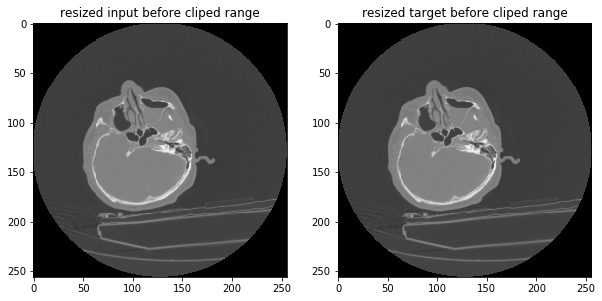

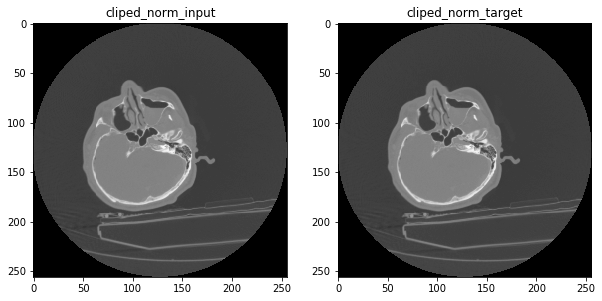

In [17]:
# check preprocessing
print("range of input: [{}, {}]".format(np.min(input), np.max(input)))
print("range of target: [{}, {}]".format(np.min(target), np.max(target)))
fig2, axes2 = plt.subplots(1,2, figsize=(10,10))
resized_input, resized_target = resize(input, target)
print("range of resized_input: [{}, {}]".format(np.min(resized_input), np.max(resized_input)))
print("range of resized_target: [{}, {}]".format(np.min(resized_target), np.max(resized_target)))

# # clipped
cliped_input = truncate(input, min=30720.0, max=34816.0)
cliped_target = truncate(target, min=30720.0, max=34816.0)
print("range of cliped_input: [{}, {}]".format(np.min(cliped_input), np.max(cliped_input)))
print("range of cliped_target: [{}, {}]".format(np.min(cliped_target), np.max(cliped_target)))


cliped_norm_input, cliped_norm_target =  linear_normalization(resized_input, resized_target)
axes2[0].imshow(np.squeeze(resized_input.numpy()), cmap='gray')
axes2[0].set_title("resized input before cliped range")
axes2[1].imshow(np.squeeze(resized_target.numpy()), cmap='gray')
axes2[1].set_title("resized target before cliped range")
print("resized input shape:", resized_input.shape)
print("range of cliped_norm_input: [{}, {}]".format(np.min(cliped_norm_input), np.max(cliped_norm_input)))
print("range of cliped_norm_target: [{}, {}]".format(np.min(cliped_norm_target), np.max(cliped_norm_target)))
# print(truncated_input.shape)
fig3, axes3 = plt.subplots(1,2, figsize=(10,10))
axes3[0].imshow(np.squeeze(cliped_norm_input.numpy()), cmap='gray')
axes3[0].set_title("cliped_norm_input")
axes3[1].imshow(np.squeeze(cliped_norm_target.numpy()), cmap='gray')
axes3[1].set_title("cliped_norm_target")

## DEFINE LOAD FUNCTION IN INPUT PIPELINE

In [7]:
def load_image_train(image_file):
    input, target= load(image_file)
    input, target = resize(input, target)
    input, target = linear_normalization(input, target)

    return input, target

def load_image_val(image_file):
    input, target = load(image_file)
    input, target = resize(input, target)
    input, target = linear_normalization(input, target)

    return input, target

## INPUT PIPELINE

In [8]:
train_dataset = tf.data.Dataset.list_files(train_dicom_paths)  # this can diretly get a list of kind of files
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
# train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.list_files(val_dicom_paths)
test_dataset = test_dataset.map(load_image_val)
test_dataset = test_dataset.batch(BATCH_SIZE)

Tensor("ReadFile:0", shape=(), dtype=string)
load image: (None, None, None, None)


In [9]:
# #  check the dataset
# for one_batch_input, one_batch_target  in train_dataset.take(1):
#     print(one_batch_input.shape)

(2, 256, 256, 1)


## DESIGN MODEL

In [10]:
OUTPUT_CHANNELS = 1
latent_dim =50

In [11]:
# model input conponents
en_inputs = tf.keras.layers.Input(shape=[IMG_HEIGHT,IMG_HEIGHT,1])
de_inputs = tf.keras.layers.Input(shape=[latent_dim])
# full model design and construct encoder, decoder , AE object
# entire model

# Define encoder part ---->
x = en_inputs
x = tf.keras.layers.Conv2D(
                filters=16, kernel_size=3, strides=(1, 1), activation='relu', padding="same")(x)
x = tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu', padding="same")(x)
x = tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu', padding="SAME")(x)
x = tf.keras.layers.Conv2D(
                filters=128, kernel_size=3, strides=(2, 2), activation='relu',padding="SAME")(x)
x = tf.keras.layers.Flatten()(x)
# No activation
latent_v = tf.keras.layers.Dense(latent_dim)(x)
encoder = tf.keras.Model(inputs=en_inputs, outputs=latent_v, name='encoder')


# Define decoder part ---->
x = tf.keras.layers.Dense(units=131072, activation=tf.nn.relu)(de_inputs)
x = tf.keras.layers.Reshape(target_shape=(32, 32, 128))(x)
x = tf.keras.layers.Conv2DTranspose(
      filters=64,
      kernel_size=3,
      strides=(2, 2),
      padding="SAME",
      activation='relu')(x)
x = tf.keras.layers.Conv2DTranspose(
      filters=32,
      kernel_size=3,
      strides=(2, 2),
      padding="SAME",
      activation='relu')(x)
x = tf.keras.layers.Conv2DTranspose(
      filters=16,
      kernel_size=3,
      strides=(2, 2),
      padding="SAME",
      activation='relu')(x)

decoded = tf.keras.layers.Conv2DTranspose(
      filters=1, kernel_size=3, strides=(1, 1), padding="SAME", use_bias=True)(x)
# output with sigmoid
decoded =  tf.sigmoid(decoded)
decoder = tf.keras.Model(inputs=de_inputs, outputs=decoded, name='decoder')


# Define AE model---->
outputs = decoder(latent_v)
autoencoder =  tf.keras.Model(inputs=en_inputs, outputs=outputs, name='AE')

# a sperately decoder is struggle leave for the moment

# # # create a placeholder for an encoded (32-dimensional) input
# encoded_input = tf.keras.layers.Input(shape=(latent_dim))
# # # retrieve the last layer of the autoencoder model
# decoder_layer = autoencoder.layers[-1]
# # # create the decoder model
# decoder = tf.keras.Model(encoded_input, decoder_layer)
             

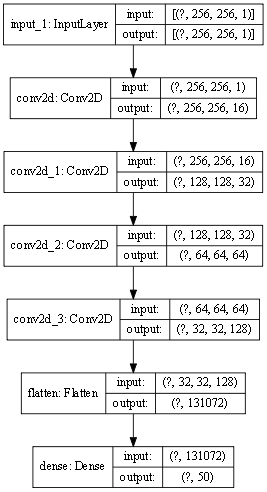

In [12]:
tf.keras.utils.plot_model(encoder, to_file="Encoder.png", show_shapes=True, dpi=64)

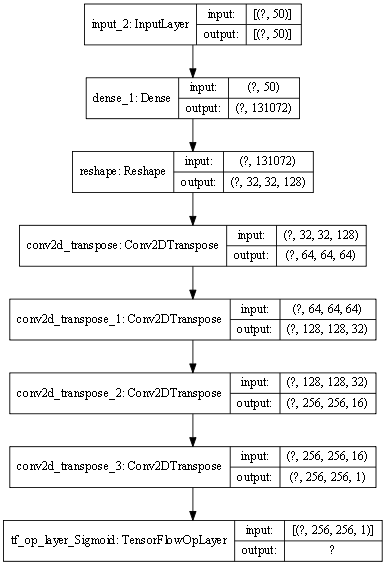

In [13]:
tf.keras.utils.plot_model(decoder, to_file="Decoder.png", show_shapes=True, dpi=64)

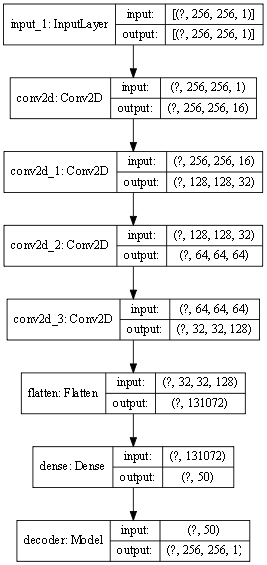

In [14]:
tf.keras.utils.plot_model(autoencoder, to_file="Autoencoder.png", show_shapes=True, dpi=64)

## OPTIMIZER AND OBJECTIVE LOSSES


In [15]:
# define opitmizer 
optimizer =  tf.keras.optimizers.Adam(1e-4)
@tf.function()
# define losses
def compute_loss(decoded_x, x):
    
    # cross_entropy,  use reduce mean not sum, otherwise loss will be very big
    CE_loss =  tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=decoded_x, labels=x))
    
    
    # L1 loss 
    L1_loss = tf.reduce_mean(tf.abs(x - decoded_x))
    
    total_loss = CE_loss + L1_loss
    return total_loss, CE_loss, L1_loss 
    
# appliy graidients  this is acutaully trianing step
# @tf.function()
# def compute_apply_gradients(model, x, optimizer, epoch):
#     decoded_x =  model(x)
#     with tf.GradientTape() as tape:
#         total_loss, CE_loss, L1_loss = compute_loss(decoded_x, x)
#     gradients = tape.gradient(total_loss, model.trainable_variables)
#     optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
#     with summary_writer.as_default():
#         # write scalars to the tensorboard after each train step
#         tf.summary.scalar('total_loss', total_loss, step=epoch)
#         tf.summary.scalar('CE_loss', CE_loss, step=epoch)
#         tf.summary.scalar('L1_loss', L1_loss, step=epoch) 
@tf.function()
def train_step(model, input, target, epoch):
    print("in trianing step")
    with tf.GradientTape() as tape:  # very interesting
        decoded_img = model(input, training=True)
        total_loss, CE_loss, L1_loss = compute_loss(decoded_img, target)
    gradients = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return total_loss, CE_loss, L1_loss

@tf.function()
def test_step(model, input, target, epoch):
    with tf.GradientTape() as tape:  # very interesting
        decoded_img = model(input, training=True)
        total_loss, CE_loss, L1_loss = compute_loss(decoded_img, target)
    return total_loss, CE_loss, L1_loss
#     train_avg_loss(train_loss)
#     train_avg_metric(metric)     

inp.shape: (256, 256, 1)
inp[tf.newaxis,...]: (1, 256, 256, 1)
(1, 256, 256, 1)


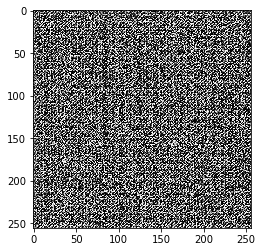

In [18]:
# check the AE OUTPUT
print("inp.shape:", cliped_norm_input.shape)
print("inp[tf.newaxis,...]:", cliped_norm_input[tf.newaxis,...].shape)
AE_output = autoencoder(resized_input[tf.newaxis,...], training=False)  # inp is the image sample from cell code 6 ; 
print(AE_output.shape)
plt.imshow(np.squeeze(AE_output[0,...]), cmap="gray")

## Training PREPARING

In [66]:

# define the epoch image check
def generate_images(model, test_input, tar,total_loss, batch_idx, epoch):
    prediction = model(test_input, training=True)

    plt.figure(figsize=(15,15))

    display_list = [np.squeeze(test_input[0]), np.squeeze(tar[0]), np.squeeze(prediction[0])]
    title = ['Input range:[{},{}]'.format(test_input[0].numpy().min(), test_input[0].numpy().max()), 
           'GT range:[{},{}]'.format(tar[0].numpy().min(), tar[0].numpy().max()), 'Pred. [B:{}/E:{}]: loss->'.format(batch_idx,epoch)+ str(total_loss)]

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i], cmap="gray") # prediction in range[-1, 1]*0.5 = [-0.5, 0.5],+ 0.5=[0, 1]
        plt.axis('off')
    plt.savefig('./AE_saves/image_at_epoch_{:04d}_batch_{}.png'.format(epoch,batch_idx+1))
    
    plt.figure(figsize=(8,8))
    plt.title('Pred. [B:{}/E:{}]: loss->'.format(batch_idx,epoch)+ str(total_loss))
    plt.imshow(np.squeeze(prediction[0]), cmap="gray") # prediction in range[-1, 1]*0.5 = [-0.5, 0.5],+ 0.5=[0, 1]
    plt.axis('off')
    plt.savefig('./AE_saves/Predictions/pred_only_at_epoch_{:04d}_batch_{}.png'.format(epoch,batch_idx+1))
    plt.show()




## TRAINING

In [72]:
import datetime
log_dir="AE_logs/"
epochs = 100

## get current working directory
cwd = os.getcwd()
print("current working directory:", cwd)


save_figure_path =  "AE_saves"

full_AE_saves =  os.path.join(cwd, save_figure_path)
print(full_AE_saves)
if not os.path.exists(full_AE_saves):
    os.makedirs(full_AE_saves)
predictions_save_path =os.path.join(full_AE_saves, "Predictions")
if not os.path.exists(predictions_save_path):
    os.makedirs(predictions_save_path)

# define check points

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
if not os.path.exists(checkpoint_prefix):
    os.makedirs(checkpoint_prefix)
#  contents of states to be saved as attributes on the checkpoint object
checkpoint_ob = tf.train.Checkpoint(step= tf.Variable(1),
                                    epoch=  tf.Variable(1),
                                    optimizer=optimizer,
                                 encoder=encoder,
                                 decoder =  decoder,
                                 autoencoder = autoencoder
                                 )
# define checkpoint manager
manager =  tf.train.CheckpointManager(checkpoint_ob, checkpoint_prefix, max_to_keep=3)


datetime_rec =  datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

train_summary_writer = tf.summary.create_file_writer(
  log_dir + "train")
val_summary_writer = tf.summary.create_file_writer(
  log_dir + "val")

current working directory: E:\Projects\TF2\Dicom
E:\Projects\TF2\Dicom\AE_saves


In [73]:
# start tensorboard
# !kill 5032
%load_ext tensorboard
%tensorboard --logdir {log_dir}

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 5032), started 4 days, 11:47:24 ago. (Use '!kill 5032' to kill it.)

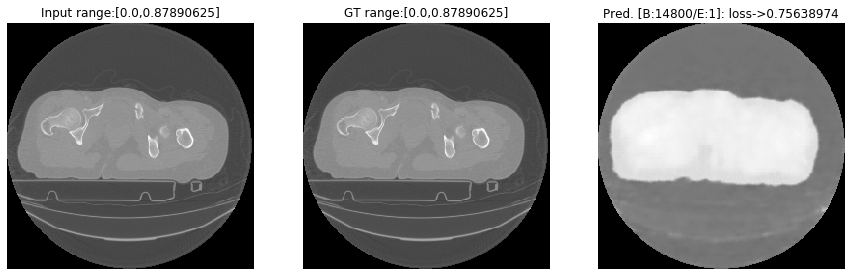

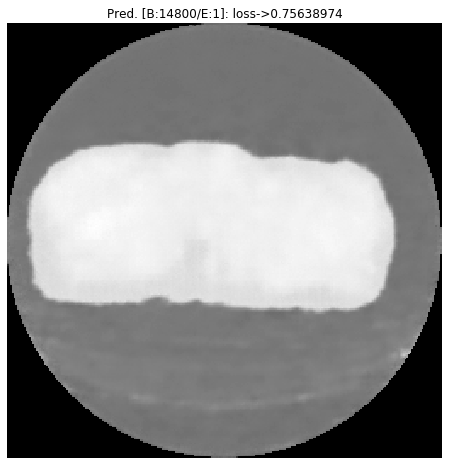

Epoch1: 14800/18312: total_loss: 0.7563897371292114 ; CE_loss:0.7353145480155945; L1_loss:0.021075189113616943  time elapse 388.72549843788147


KeyboardInterrupt: 

In [74]:
import time

# check the whether there is a checkpoint in the checkpoint folder, if it is restore from it
if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
    checkpoint_ob.restore(manager.latest_checkpoint)
else:
    print("Initializing from scratch.")
    
for epoch in range(1, epochs+1):
    train_total_loss_mean = tf.keras.metrics.Mean()
    train_CE_loss_mean = tf.keras.metrics.Mean()
    train_L1_loss_mean = tf.keras.metrics.Mean()
    
    # reset checkcpoint.step for each epoch
    step =  checkpoint_ob.step
    step.assign(1)
    ckpt_epoch =  checkpoint_ob.epoch
    # initial saving of checkpoints
    if epoch % 1 == 0:
        save_path =  manager.save()
        print("Initial saving checkpoints at epoch {} batch {} at path {}".format(int(ckpt_epoch),  int(step) ,save_path))
       
        
    
    start_time =  time.time()
    for train_x, target in train_dataset:
#         print(train_x.shape)
#         print(target.shape)
#         print(autoencoder)
        # one training step
        total_loss, CE_loss, L1_loss = train_step(autoencoder, train_x, target, epoch)
        end_time =  time.time()
        
        # calculate mean value for trainning losses
        train_total_loss_mean(total_loss)
        train_CE_loss_mean(CE_loss)   
        train_L1_loss_mean(L1_loss) 
       
        #
        if int(step) == 1:
            for example_input, example_target in test_dataset.take(1):
                generate_images(autoencoder, example_input, example_target,total_loss.numpy(), int(step), epoch)
        
        # every 100 batch step show the generate test image to check.
        if int(step) % 100 == 0:
            display.clear_output(wait=True)   
            for example_input, example_target in test_dataset.take(1):
                generate_images(autoencoder, example_input, example_target,total_loss.numpy(), int(step), epoch)
                # every 400 steps save the genrate images
          
            print('Epoch{}: {}/{}: total_loss: {} ; CE_loss:{}; L1_loss:{}  '
          'time elapse {}'.format(int(ckpt_epoch), int(step), total_num_batches_per_epoch, total_loss, CE_loss, L1_loss, end_time-start_time))
                       
             
        
          
        
        step.assign_add(1)
        
    # print validation step
    if epoch % 1 == 0:
        test_total_loss_mean = tf.keras.metrics.Mean()
        test_CE_loss_mean = tf.keras.metrics.Mean()
        test_L1_loss_mean = tf.keras.metrics.Mean()
        for (test_x, test_target) in test_dataset:
            test_total_loss, test_CE_loss, test_L1_loss = test_step(autoencoder, test_x, test_target, epoch)
            test_total_loss_mean(test_total_loss)
            test_CE_loss_mean(test_CE_loss)   
            test_L1_loss_mean(test_L1_loss)                                                            
      
        
        print('Epoch: {}, Test total_loss set loss: {},  time elapse for current epoch {}'.format(int(ckpt_epoch),
                                                    test_total_loss_mean.result(),
                                                    end_time - start_time))
        
        with train_summary_writer.as_default():
            print("writing train logs to tensorboard...")                                                       
            # write scalars to the tensorboard after each train step
            tf.summary.scalar('total_loss', train_total_loss_mean.result(), step=epoch)
            tf.summary.scalar('CE_loss', train_CE_loss_mean.result(), step=epoch)
            tf.summary.scalar('L1_loss', train_L1_loss_mean.result(), step=epoch) 
        
        with val_summary_writer.as_default():
            print("writing val logs to tensorboard...")                                                        
            # write scalars to the tensorboard after each train step
            tf.summary.scalar('total_loss', test_total_loss_mean.result(), step=epoch)
            tf.summary.scalar('CE_loss', test_CE_loss_mean.result(), step=epoch)
            tf.summary.scalar('L1_loss', test_L1_loss_mean.result() , step=epoch)
        
        save_path =  manager.save() # save the checkpoint and return the save path
        print("Saved checkpoint for epoch {}-  step {}: {}".format(int(ckpt_epoch), int(step), save_path))
        
    ckpt_epoch.assign_add(1)     
    
#     # saving (checkpoint) the model every 5 epochs
#     if epoch % 5 == 0:
#         print("saving checkpoints at epoch {}".format(epoch))
#         checkpoint.save(file_prefix = checkpoint_prefix)

print("training finished")   


### Generate a GIF of all the saved images.

In [32]:

print("found save figures #: ",len(glob(full_AE_saves+ '/*.png')))

found save figures #:  114


In [ ]:
anim_file = 'AE_saves.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob(full_AE_saves+ '/*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info >= (6,2,0,''):
  display.Image(filename=anim_file)